# AXA Data Challenge Report notebook
## Group: Yellow

In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Some constants

In [219]:
date = 'DATE'
ass = 'ASS_ASSIGNMENT'
target = 'CSPL_RECEIVED_CALLS'

In [273]:
day_off_2011 = ['2011-01-01','2011-04-24','2011-04-25','2011-05-01','2011-05-08',
                '2011-06-02','2011-06-12','2011-06-13','2011-07-14','2011-08-15',
                '2011-11-01','2011-11-11','2011-12-25']
day_off_2012 = ['2012-01-01','2012-04-08','2012-04-09','2012-05-01','2012-05-08',
                '2012-05-17','2012-05-27','2012-05-28','2012-07-14','2012-08-15',
                '2012-11-01','2012-11-11','2012-12-25']
day_off_2013 = ['2013-01-01','2013-03-31','2013-04-01','2013-05-01','2013-05-08',
                '2013-05-09','2013-05-19','2013-05-20','2013-07-14','2013-08-15',
                '2013-11-01','2013-11-11','2013-12-25']
day_off_all = day_off_2011 + day_off_2012 + day_off_2013
day_off_date = [pd.to_datetime(x).date() for x in day_off_all]

### Read data

In [2]:
%%time
df = pd.read_csv('train_2011_2012_2013.csv',sep=';')

/Users/Evariste/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [243]:
df[date] = pd.to_datetime(df[date])
df[ass] = df[ass].astype('category')
df.shape

(10878470, 86)

In [247]:
df[[ass,date,target]][df[target]>20].loc[(df[ass]=='Téléphonie') & (df[date]==pd.to_datetime('2013-11-18 11:30:00') )]

,ASS_ASSIGNMENT,DATE,CSPL_RECEIVED_CALLS
9696073,Téléphonie,2013-11-18 11:30:00,53
9696307,Téléphonie,2013-11-18 11:30:00,72
9696347,Téléphonie,2013-11-18 11:30:00,24
9696369,Téléphonie,2013-11-18 11:30:00,28
9696372,Téléphonie,2013-11-18 11:30:00,53
9696375,Téléphonie,2013-11-18 11:30:00,33
9696392,Téléphonie,2013-11-18 11:30:00,24
9696404,Téléphonie,2013-11-18 11:30:00,135
9696415,Téléphonie,2013-11-18 11:30:00,26
9696441,Téléphonie,2013-11-18 11:30:00,40


### Remark

There are duplicated lines of the same ASS_ASSIGNMENT and DATE. We need to do a groupby and sum them up.

In [126]:
df_useful = df[[date,ass,target]].groupby([date, ass])[target].aggregate(np.sum)
df_useful = df_useful.reset_index()
df_useful.shape

(1030829, 3)

In [148]:
df_useful.head()

,DATE,ASS_ASSIGNMENT,CSPL_RECEIVED_CALLS
0,2011-01-01,Crises,0
1,2011-01-01,Domicile,0
2,2011-01-01,Gestion,0
3,2011-01-01,Gestion - Accueil Telephonique,0
4,2011-01-01,Gestion Amex,0


In [149]:
def get_slot(timestamp):
    """get the time slot of the day (0 for 00:00, 1 for 00:30, ... 47 for 23:30)"""
    return 2 * timestamp.hour + (timestamp.minute == 30)

### Some reasonable feature candidates could be
- time slot
- ASS_ASSIGNMENT
- weekday
- month
- year

In [295]:
%%time
feature_df = df_useful.copy()
feature_df['slot'] = feature_df.DATE.apply(get_slot)
feature_df['dayofweek'] = feature_df.DATE.apply(lambda x: x.dayofweek).astype('category')
feature_df['month'] = feature_df.DATE.apply(lambda x: x.month).astype('category')
feature_df['year'] = feature_df.DATE.apply(lambda x: x.year).astype('category')

CPU times: user 18 s, sys: 1.92 s, total: 20 s
Wall time: 21.4 s


#### And other useful features might be 
- whether it's a day off or not
- whether it's a day after day off

In [280]:
def is_day_off(timestamp):
    return timestamp.date() in day_off_date

def is_day_after_day_off(timestamp):
    return (timestamp + pd.DateOffset(-1)).date() in day_off_date

In [297]:
%%time
feature_df['day_off'] = feature_df.DATE.apply(is_day_off)
feature_df['day_after_day_off'] = feature_df.DATE.apply(is_day_after_day_off)

CPU times: user 33.2 s, sys: 1.45 s, total: 34.7 s
Wall time: 35.9 s


In [298]:
feature_df.head()

,DATE,ASS_ASSIGNMENT,CSPL_RECEIVED_CALLS,slot,dayofweek,month,year,day_off,day_after_day_off
0,2011-01-01,Crises,0,0,5,1,2011,True,False
1,2011-01-01,Domicile,0,0,5,1,2011,True,False
2,2011-01-01,Gestion,0,0,5,1,2011,True,False
3,2011-01-01,Gestion - Accueil Telephonique,0,0,5,1,2011,True,False
4,2011-01-01,Gestion Amex,0,0,5,1,2011,True,False


# Data visualization and preliminary analysis

In [205]:
ass_unique = sorted(feature_df[ass].unique())
month_unique = sorted(feature_df['month'].unique())
day_unique = sorted(feature_df['dayofweek'].unique())

## Average number of calls for each time slot

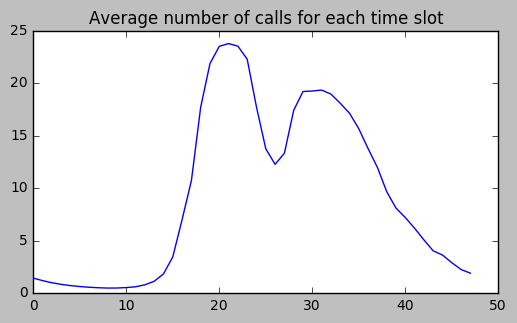

In [245]:
plt.figure(figsize=(6,3))
plt.plot(feature_df.groupby('slot')[target].agg('mean'))
plt.title('Average number of calls for each time slot');

#### Observation:
We have two peaks at around 10:00-11:00 and 14:30-15:30

## Impact of ASS_ASSIGNMENT
We draw the average number of calls w.r.t. time slot for each ASS_ASSIGNMENT.

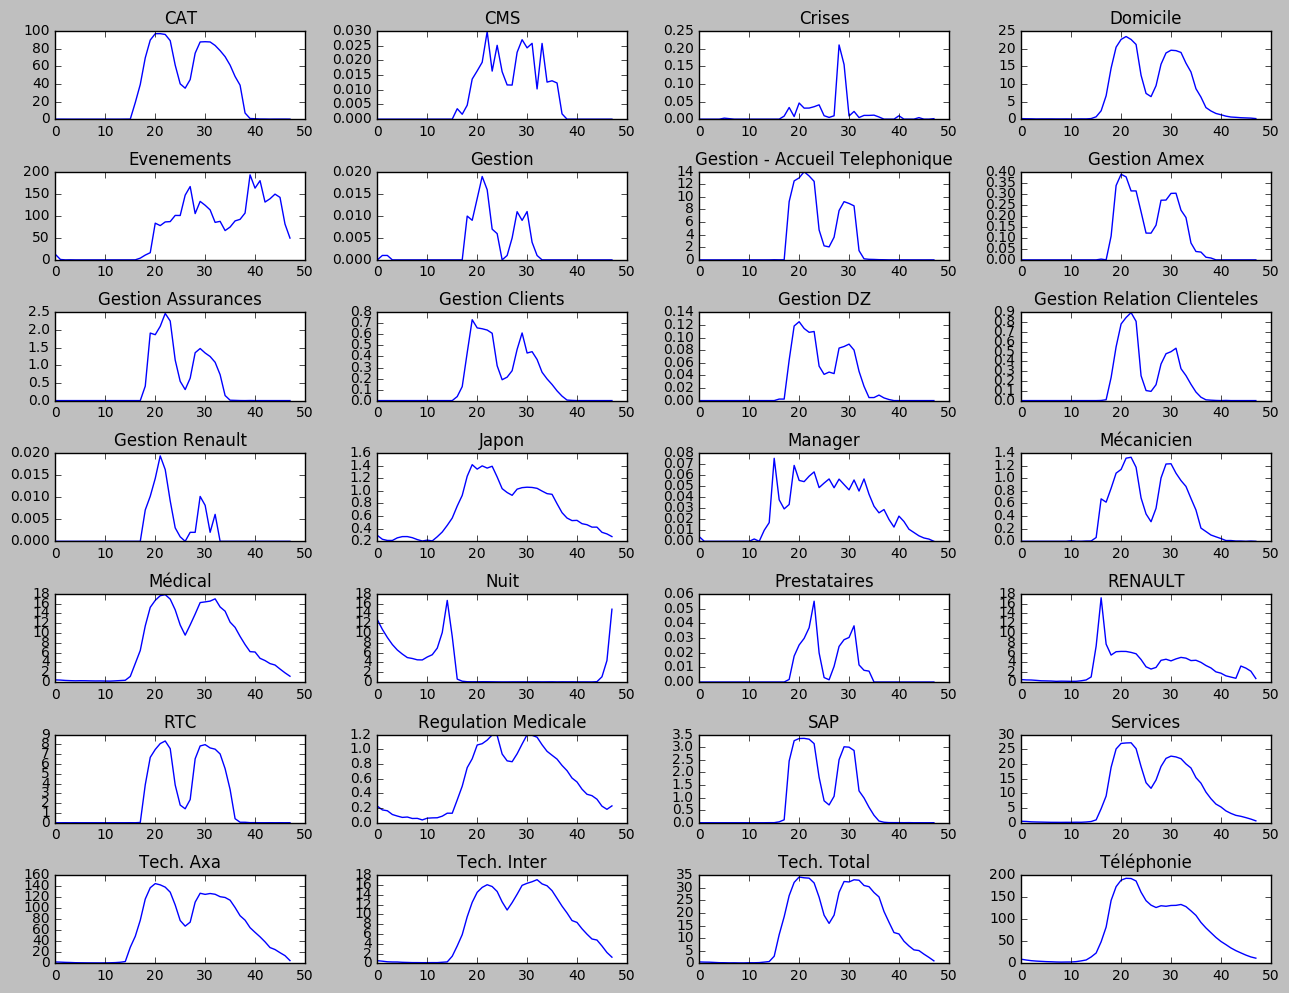

In [246]:
for i, a in enumerate(ass_unique):
    plt.subplot(7, 4, i+1)
    plt.plot(feature_df[feature_df.ASS_ASSIGNMENT == a].groupby('slot')[target].agg('mean'))
    plt.title(a)
plt.tight_layout()

#### Observation:
- The curves are indeed quite different for different ASS_ASSIGNMENT, which means that ASS_ASSIGNMENT is an import feature;
- Most of them have two peaks just as the average curve. But there are some exceptions, e.g. Nuit.

## Impact of year
We draw the average number of calls w.r.t. time slot for each year.

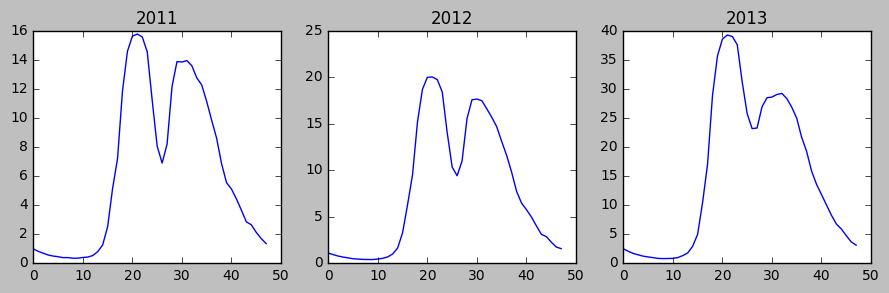

In [306]:
plt.figure(figsize=(9,3))
for i, year in enumerate([2011,2012,2013]):
    plt.subplot(1, 3, i+1)
    plt.plot(feature_df[feature_df['year'] == year].groupby('slot')[target].agg('mean'))
    plt.title(year)
plt.tight_layout()
plt.show()

#### Observation:
- Average number of calls in increasing order: 2011 < 2012 < 2013

## Impact of month
We draw the average number of calls w.r.t. time slot for each month.

1 for January and 12 for December

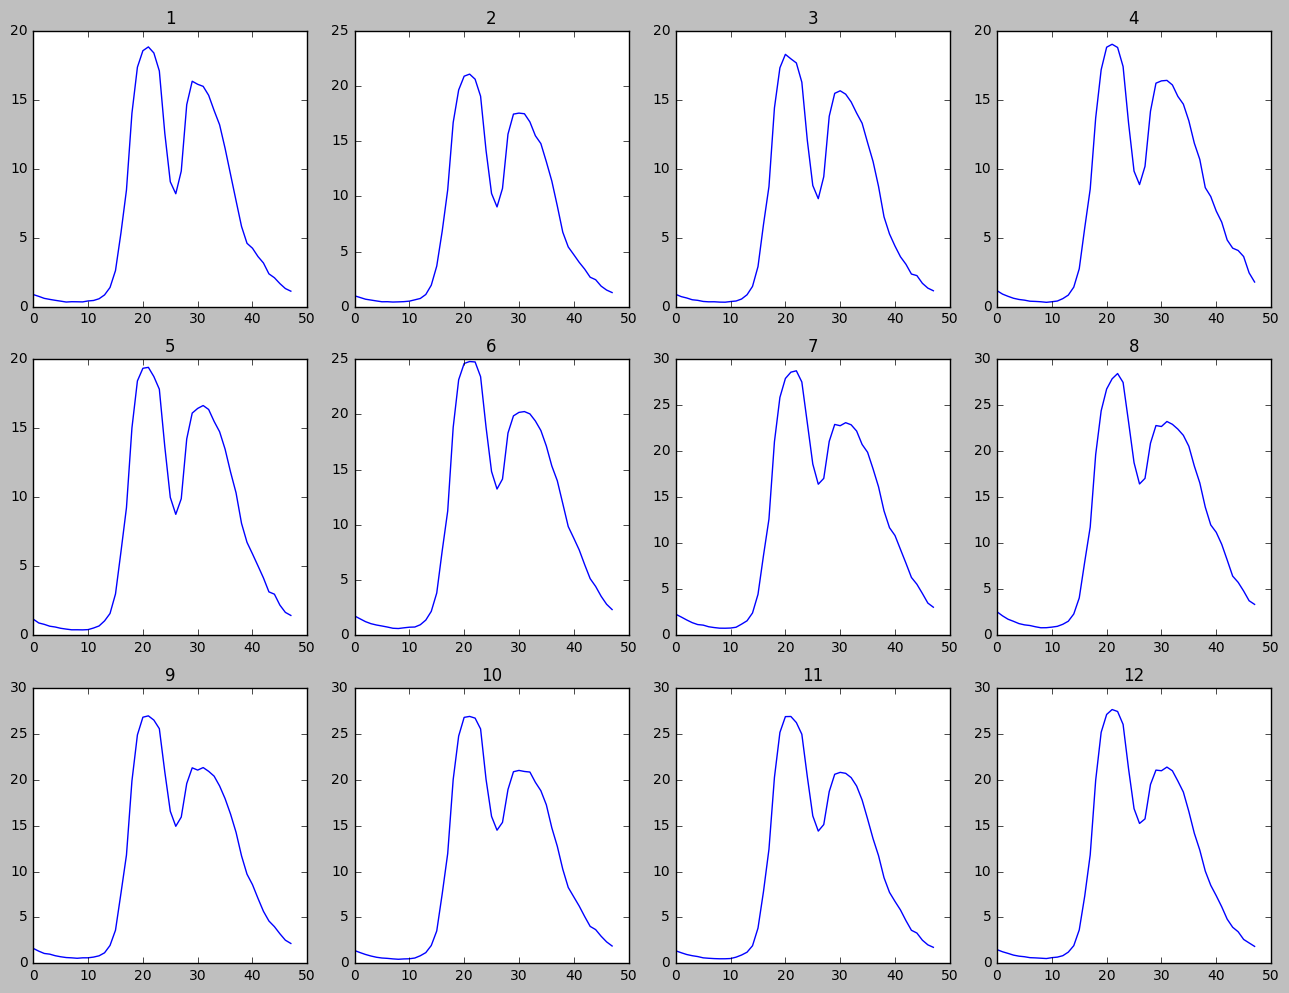

In [233]:
for i, mon in enumerate(month_unique):
    plt.subplot(3, 4, i+1)
    plt.plot(feature_df[feature_df['month'] == mon].groupby('slot')[target].agg('mean'))
    plt.title(mon)
plt.tight_layout()
plt.show()

#### Observation:
- The feature 'month' doesn't have much impact on the profile of the curves;
- But we notice that we tend to have more calls in the summer and less calls in the winter.

## Impact of weekday
We draw the average number of calls w.r.t. time slot for each weekday.

0 for Monday and 6 for Sunday

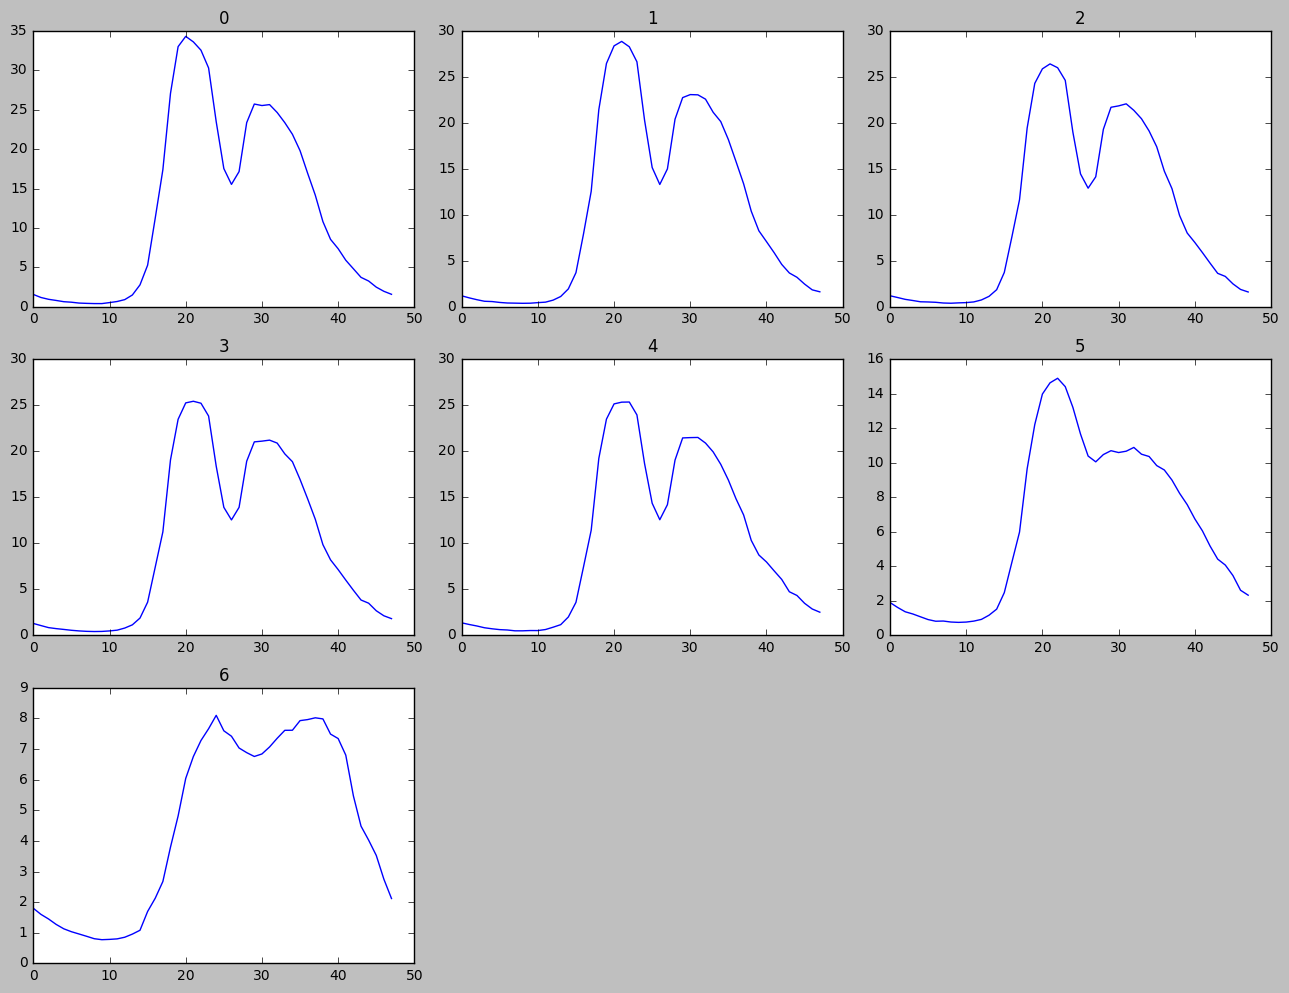

In [248]:
for i, weekday in enumerate(day_unique):
    plt.subplot(3, 3, i+1)
    plt.plot(feature_df[feature_df['dayofweek'] == weekday].groupby('slot')[target].agg('mean'))
    plt.title(weekday)
plt.tight_layout()
plt.show()

#### Observation:
- There are much fewer calls during the weekend than during the week;
- We tend to have more calls on Monday than the other weekdays.

## Impact of day_off
We draw the average number of calls w.r.t. time slot depending on whether the day is a day off or not.

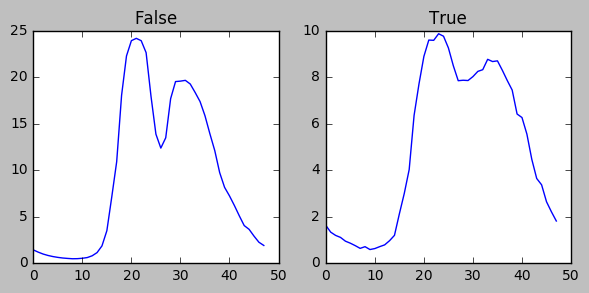

In [302]:
plt.figure(figsize=(6,3))
for i, istrue in enumerate([False,True]):
    plt.subplot(1, 2, i+1)
    plt.plot(feature_df[feature_df['day_off'] == istrue].groupby('slot')[target].agg('mean'))
    plt.title(istrue)
plt.tight_layout()
plt.show()

#### Observation:
- There are fewer calls on a day off

## Impact of day_after_day_off
We draw the average number of calls w.r.t. time slot depending on if the day is a day after a day off.

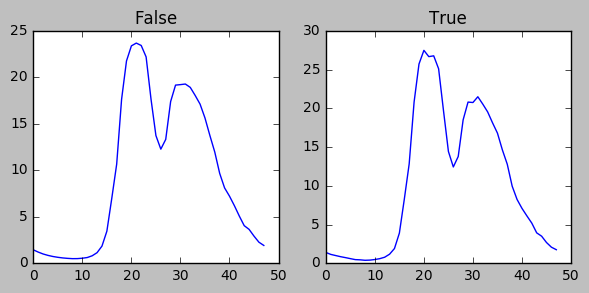

In [303]:
plt.figure(figsize=(6,3))
for i, istrue in enumerate([False,True]):
    plt.subplot(1, 2, i+1)
    plt.plot(feature_df[feature_df['day_after_day_off'] == istrue].groupby('slot')[target].agg('mean'))
    plt.title(istrue)
plt.tight_layout()
plt.show()

#### Observation:
- We tend to get a bit more calls when it's a day after a day off.

In [268]:
pd.to_datetime('2013-11-01').date() in day_off_date

True

In [22]:
day_off.date()

datetime.date(2011, 1, 6)